In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.models import vgg16

class YourClass:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build_model(self):
        model = vgg16(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False

        # Customize top layers
        num_features = model.classifier[6].in_features
        features = list(model.classifier.children())[:-1]  # Remove last layer
        features.extend([nn.Linear(num_features, 1024), nn.ReLU(inplace=True), nn.Linear(1024, self.num_classes)])
        model.classifier = nn.Sequential(*features)

        return model

# Define input shape and number of classes
input_shape = (224, 224)
num_classes = 5

# Instantiate YourClass
your_class_instance = YourClass(input_shape, num_classes)

# Build model
model = your_class_instance.build_model()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Moved this line up to ensure the model is on the GPU if available

if torch.cuda.is_available():
    print("Using CUDA")
    print("CUDA Device:", torch.cuda.get_device_name(0))  # Print the name of the CUDA device
else:
    print("CUDA is not available. Using CPU.")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Data preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_shape),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_shape),
        transforms.CenterCrop(input_shape),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './data'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

image_datasets = {
    'train': datasets.ImageFolder(root=train_dir, transform=data_transforms['train']),
    'val': datasets.ImageFolder(root=val_dir, transform=data_transforms['val'])
}

test_dataset = datasets.ImageFolder(root=test_dir, transform=data_transforms['val'])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

/home/unix/projects/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/unix/projects/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/unix/projects/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using CUDA
CUDA Device: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
from tqdm import tqdm

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Use tqdm for progress bar
        with tqdm(dataloaders[phase], unit="batch") as tepoch:
            tepoch.set_description(f'{phase.capitalize()} Epoch {epoch + 1}/{num_epochs}')
            for inputs, labels in tepoch:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                tepoch.set_postfix(loss=loss.item())

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

Epoch 1/10


Train Epoch 1/10:  15%|█████                              | 102/698 [00:39<03:49,  2.60batch/s, loss=0.0567]


KeyboardInterrupt: 

In [7]:
# Test the model
correct = 0
total = 0
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


Accuracy of the network on the test images: 94 %


Confusion Matrix:
[[ 225    3    0    0    0]
 [  26  249    0    0   27]
 [   0    0 1867    0    0]
 [   1    0    0  176    0]
 [   0    1    0    0  239]]


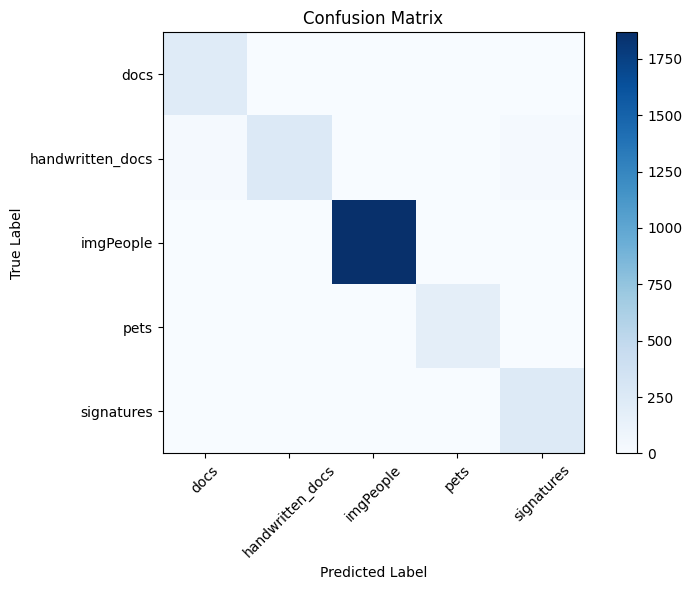

In [11]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Make predictions on the validation dataset
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())  # Convert labels to numpy array
        predicted_labels.extend(preds.cpu().numpy())  # Convert predictions to numpy array

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = image_datasets['val'].classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()

# Display the confusion matrix
print('Confusion Matrix:')
print(conf_matrix)

plt.show()


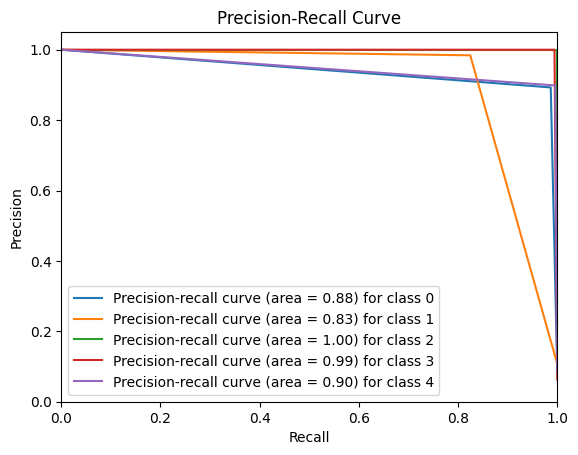

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Binarize the true labels and predicted labels
true_labels_bin = label_binarize(true_labels, classes=range(num_classes))
predicted_labels_bin = label_binarize(predicted_labels, classes=range(num_classes))

# Compute precision-recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
    average_precision[i] = average_precision_score(true_labels_bin[:, i], predicted_labels_bin[:, i])

# Plot Precision-Recall curve
plt.figure()
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label='Precision-recall curve (area = %0.2f) for class %d' % (average_precision[i], i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()


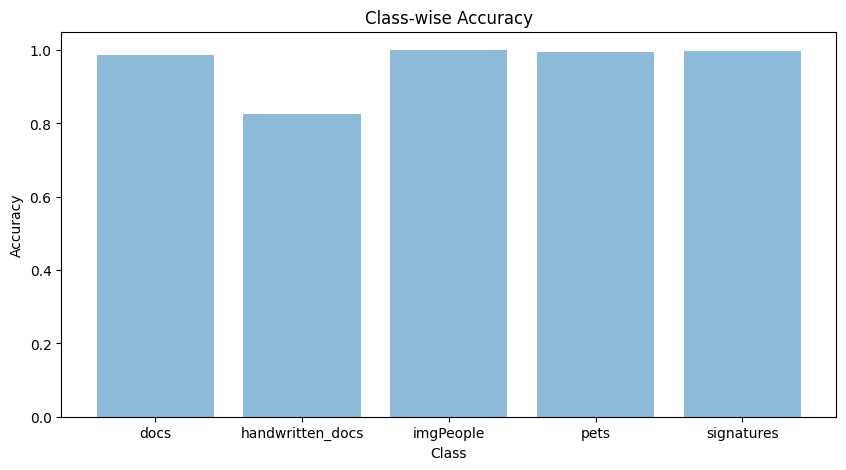

In [15]:
# Calculate class-wise accuracy
class_correct = np.zeros(num_classes)
class_total = np.zeros(num_classes)
for i in range(len(true_labels)):
    class_correct[true_labels[i]] += (true_labels[i] == predicted_labels[i])
    class_total[true_labels[i]] += 1

class_accuracy = class_correct / class_total

# Plot class-wise accuracy bar graph
plt.figure(figsize=(10, 5))
plt.bar(range(num_classes), class_accuracy, align='center', alpha=0.5)
plt.xticks(range(num_classes), classes)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()


In [9]:
# Specify the file path where you want to save the model
model_path = 'top.pth'

# Save the model
torch.save(model.state_dict(), model_path)

print("Model saved successfully.")


Model saved successfully.
